## Data Understanding

In any Data Mining project, understanding your data is crucial. This phase consists of a deep dive into the data, ensuring it's ready for analysis and relevant variables are identified. It's the base upon which we build for data preprocessing and modeling.

This notebook describes the analysis of each table in the given dataset. The goal is to understand the data and identify any issues that need to be addressed before modeling.

In [105]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr

DATA_PATH = 'data'
DATA_TEAMS = 'teams.csv'
DATA_COACHES = 'coaches.csv'
DATA_AWARDS = 'awards_players.csv'
DATA_PLAYERS = 'players.csv'
DATA_PLAYERS_TEAMS = 'players_teams.csv'
DATA_SERIES_POST = 'series_post.csv'
DATA_TEAMS_POST = 'teams_post.csv'

In [106]:
# Read the CSV files into data frames
awards_df = pd.read_csv(f'{DATA_PATH}/{DATA_AWARDS}')
coaches_df = pd.read_csv(f'{DATA_PATH}/{DATA_COACHES}')
players_df = pd.read_csv(f'{DATA_PATH}/{DATA_PLAYERS}')
players_teams_df = pd.read_csv(f'{DATA_PATH}/{DATA_PLAYERS_TEAMS}')
teams_df = pd.read_csv(f'{DATA_PATH}/{DATA_TEAMS}')
teams_post_df = pd.read_csv(f'{DATA_PATH}/{DATA_TEAMS_POST}')
series_post_df = pd.read_csv(f'{DATA_PATH}/{DATA_SERIES_POST}')

## Awards Table

This file defines the awards given to each player or coach throughout the years.
Most of the columns are used for identification purposes, excluding the `award` column, which holds the name of the award given.

In [107]:
print(awards_df.info())
print(awards_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  95 non-null     object
 1   award     95 non-null     object
 2   year      95 non-null     int64 
 3   lgID      95 non-null     object
dtypes: int64(1), object(3)
memory usage: 3.1+ KB
None
playerID    0
award       0
year        0
lgID        0
dtype: int64


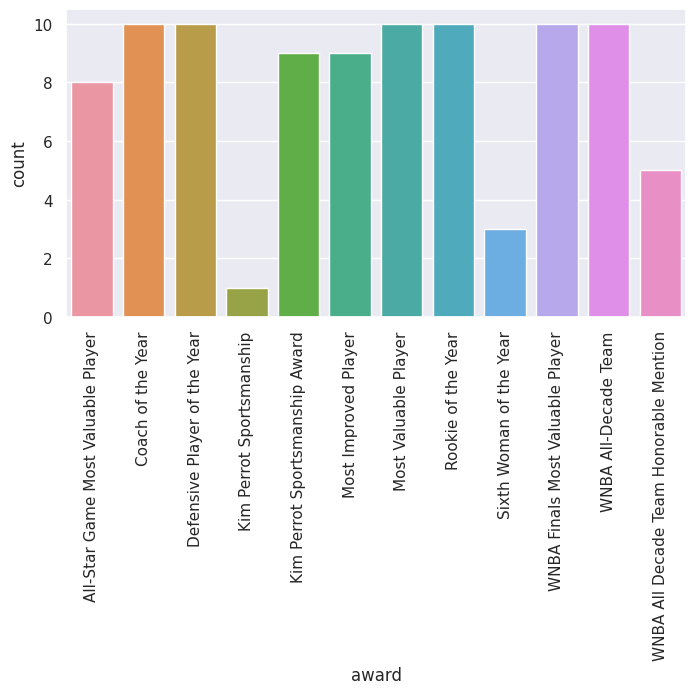

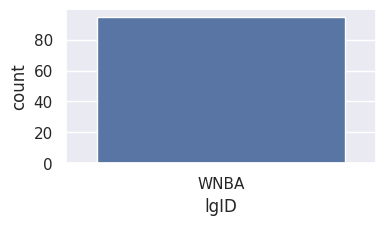

In [108]:
# Plot count plots for award
plt.figure(figsize=(8, 4))
sb.countplot(x='award', data=awards_df)
plt.xticks(rotation=90)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(4, 2))
sb.countplot(x='lgID', data=awards_df)
plt.show()

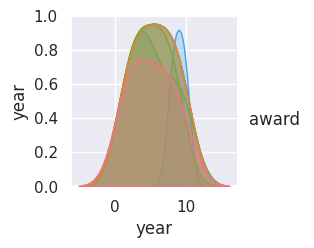

In [109]:
%matplotlib inline
sb.pairplot(awards_df, hue ='award')

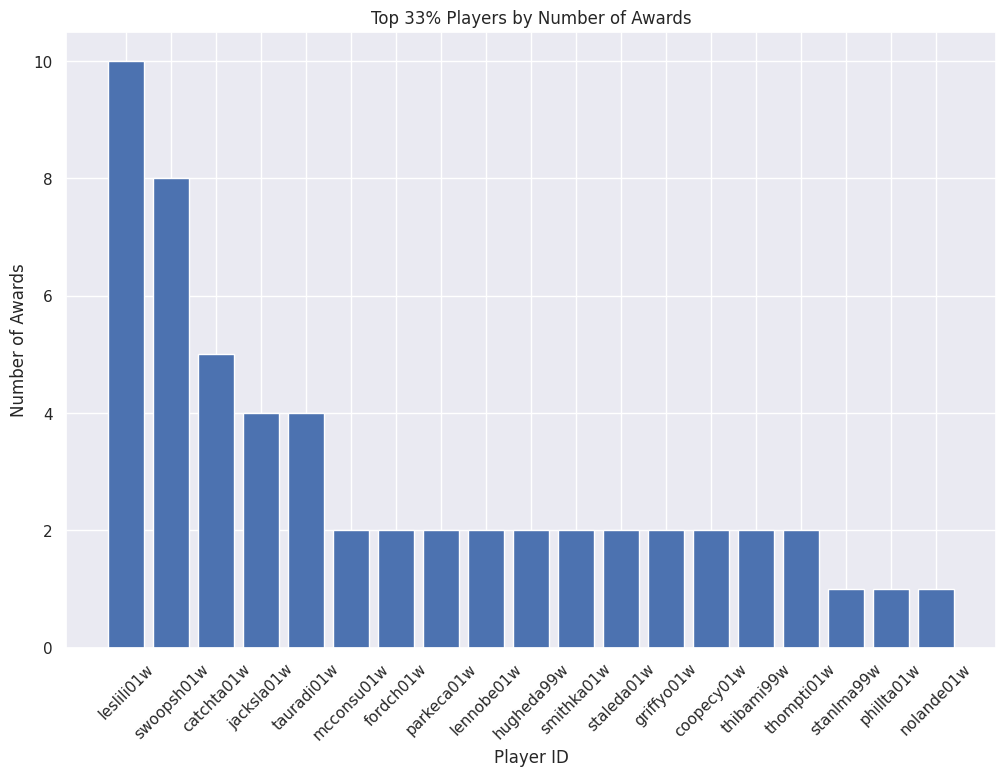

In [110]:
# Group by playerID and count the number of awards
award_counts = awards_df.groupby("playerID")["award"].count().reset_index()

# Sort players by the number of awards in descending order
award_counts = award_counts.sort_values(by="award", ascending=False)

# Calculate the number of players in the top 20%
top_33_percent = int(0.33 * len(award_counts))

# Select the top 20% of players
top_players = award_counts.head(top_33_percent)

# Create a bar plot for the top 20% of players
plt.figure(figsize=(12, 8))
plt.bar(top_players["playerID"], top_players["award"])
plt.xlabel("Player ID")
plt.ylabel("Number of Awards")
plt.title("Top 33% Players by Number of Awards")
plt.xticks(rotation=45)
plt.show()

Some important points surge from the analysis above:
 - `lgID` always has the value "WNBA" (useless)
 - The table does not have null/missing values
 - `leslili01w` is the player with most awards (10).

Furthermore, we will try to understand if the number of awards are somewhat related to the success of a team.


No team found for player coopecy01w in year 7
No team found for player boltoru01w in year 7
No team found for player weathte01w in year 7

Point-biserial correlation coefficient: 0.4380356549953016
P-value: 4.989150717685987e-08


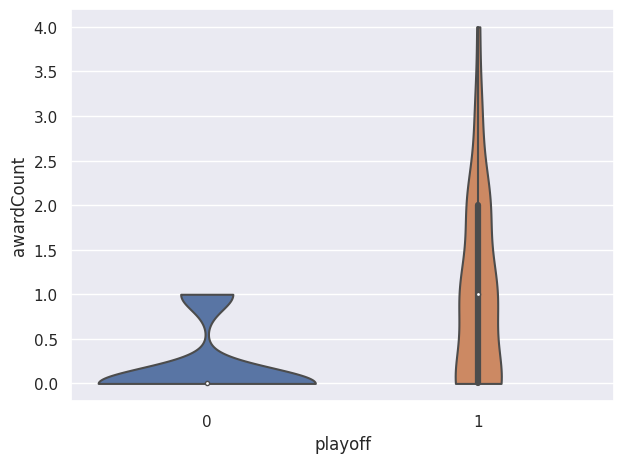

In [132]:
# Get the amount of awards in a team
for index, row in awards_df.iterrows():
    # add to awards_df
    tmId = players_teams_df.loc[(players_teams_df['playerID'] == row['playerID']) & (players_teams_df['year'] == row['year'])]['tmID']
    try:
        awards_df.loc[index, 'teamID'] = tmId.iloc[0] 
    except IndexError:
        try:
            tmId = coaches_df.loc[(coaches_df['coachID'] == row['playerID']) & (coaches_df['year'] == row['year'])]['tmID']
            #print(f'No team found for player {row["playerID"]} in year {row["year"]}')
            awards_df.loc[index, 'teamID'] = tmId.iloc[0]
        except:
            print(f'No team found for player {row["playerID"]} in year {row["year"]}')
            awards_df.loc[index, 'teamID'] = 'None'

teams_df_temp = teams_df.copy()
for index, row in teams_df_temp.iterrows():
    teams_df_temp.loc[index, 'awardCount'] = len(awards_df.loc[(awards_df['teamID'] == row['tmID']) & (awards_df['year'] == row['year'])].index)

teams_df_temp['playoff'] = teams_df_temp['playoff'].eq('Y').mul(1)

correlation_coefficient, p_value = pointbiserialr(teams_df_temp['awardCount'], teams_df_temp['playoff'])

# Print the result
print(f"\nPoint-biserial correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

sb.violinplot(x='playoff', y='awardCount', data=teams_df_temp, cut=0)
plt.tight_layout()
plt.show()


From the analysis of the violin plot above, we can conclude that the amount of awards has a positive impact in determining if a team will get to the playoffs.
Most teams without awards did not qualify.
Teams with one award are approximately evenly distributed between going to the playoff or not.
Moreover, **all** teams with more than one award went on to play in the playoffs.

Because we are comparing the binary variable `playoff` with the continuos amount of awards, we calculated the Point Biserial correlation between the two.
This metric yielded a value of 0.44, which confirms the theory that the amount of awards does influence a positive result in the series.

Finally, we also noticed that some of the players mentioned in the awards are missing from the database. This can be specially problematic as the players lost are probabily good and thus very influential for a team.

## Coaches

#### Basic Info 

In [ ]:
# Display the first few rows of the dataset
#print(coaches_df.head())

# Get information about the columns and data types (missing values)
print(coaches_df.info())

# Get basic statistics of numerical columns
print(coaches_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   coachID      162 non-null    object
 1   year         162 non-null    int64 
 2   tmID         162 non-null    object
 3   lgID         162 non-null    object
 4   stint        162 non-null    int64 
 5   won          162 non-null    int64 
 6   lost         162 non-null    int64 
 7   post_wins    162 non-null    int64 
 8   post_losses  162 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 11.5+ KB
None
             year       stint         won        lost   post_wins  post_losses
count  162.000000  162.000000  162.000000  162.000000  162.000000   162.000000
mean     5.314815    0.364198   14.672840   14.623457    1.166667     1.172840
std      2.896715    0.693861    6.403445    5.678789    1.953656     1.316782
min      1.000000    0.000000    0.000000    2.000000    0.000000     0.0

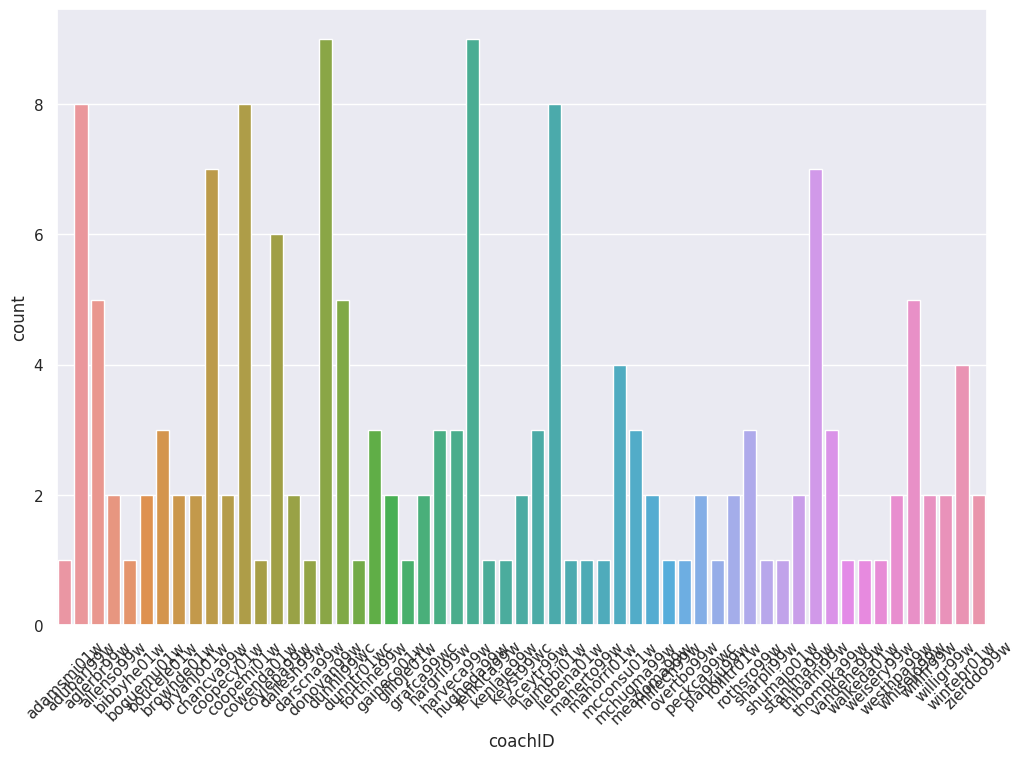

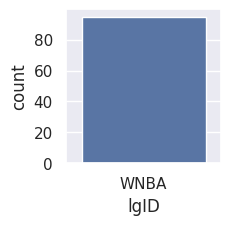

In [ ]:
# Plot count plots for award
plt.figure(figsize=(12, 8))
sb.countplot(x='coachID', data=coaches_df)
plt.xticks(rotation=45)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(2, 2))
sb.countplot(x='lgID', data=awards_df)
plt.show()

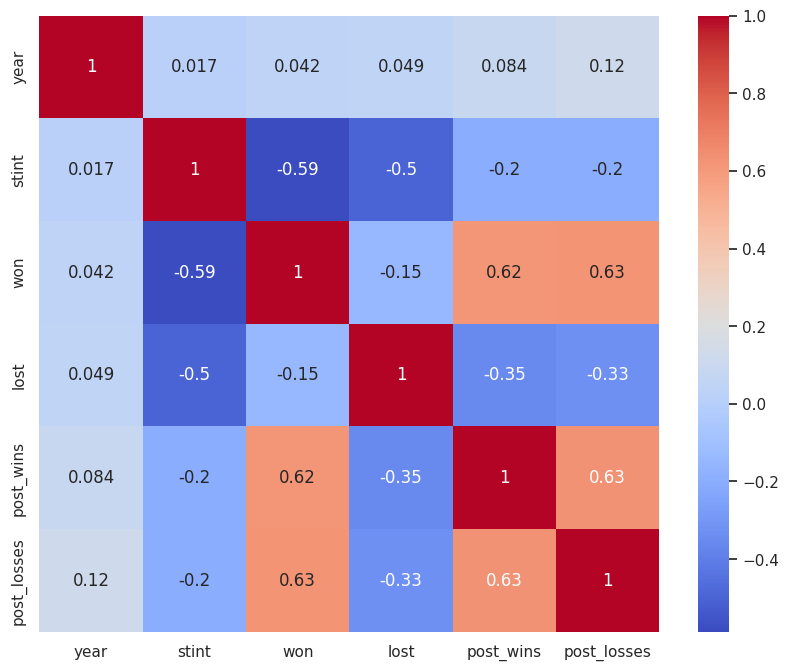

In [ ]:
# Calculate the correlation matrix
#remove strings
c_df = coaches_df.drop(['coachID', 'tmID', 'lgID'], axis=1)
correlation_matrix = c_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# %matplotlib inline
# sb.pairplot(coaches_df, hue ='coachID')

#USELESS

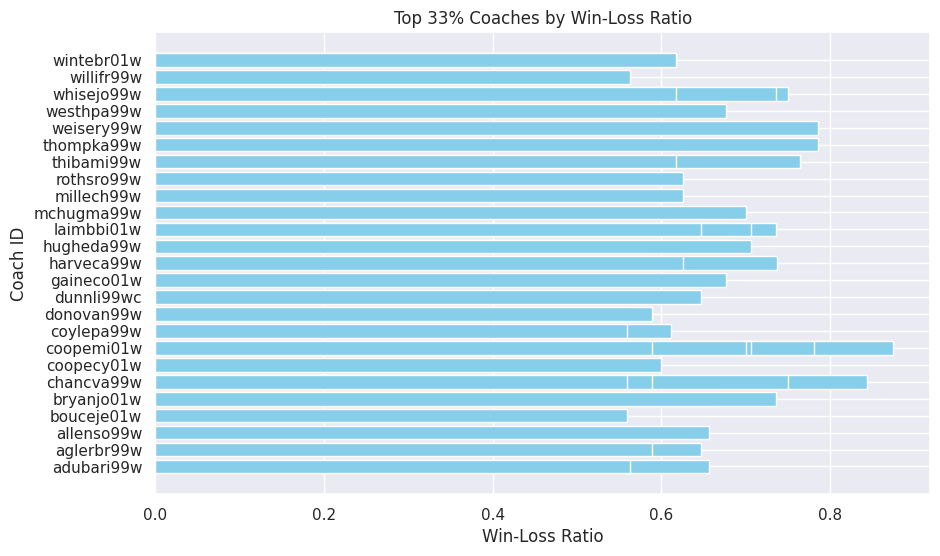

In [ ]:
import matplotlib.pyplot as plt

# Calculate win-loss ratio for each coach
coaches_df["win_loss_ratio"] = coaches_df["won"] / (coaches_df["won"] + coaches_df["lost"])

# Calculate the threshold for the top 33%
threshold = coaches_df["win_loss_ratio"].quantile(0.67)  # 67th percentile

# Filter coaches with win-loss ratio above the threshold
top_coaches = coaches_df[coaches_df["win_loss_ratio"] > threshold]

# Create a horizontal bar chart for the top coaches
plt.figure(figsize=(10, 6))
plt.barh(top_coaches["coachID"], top_coaches["win_loss_ratio"], color='skyblue')
plt.xlabel('Win-Loss Ratio')
plt.ylabel('Coach ID')
plt.title('Top 33% Coaches by Win-Loss Ratio')
plt.show()


### Coaches info

lgID is always 'WNBA' <br>
Table has no null values <br>
Interesting atriute would be win-loss ratio <br>
'coopemi01w' has the best win-loss ratio<br>
Atributes "won","lost","post_wins","post_losses" should be removed for tranining since it reveals results of season <br>
"Stint means how many seasons they are with that team" -> inaccurate

## Players_Teams 

Basic Info

In [ ]:
# Display the first few rows of the dataset
#print(coaches_df.head())

# Get information about the columns and data types (missing values)
print(players_teams_df.info())

# Get basic statistics of numerical columns
print(players_teams_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   playerID            1876 non-null   object
 1   year                1876 non-null   int64 
 2   stint               1876 non-null   int64 
 3   tmID                1876 non-null   object
 4   lgID                1876 non-null   object
 5   GP                  1876 non-null   int64 
 6   GS                  1876 non-null   int64 
 7   minutes             1876 non-null   int64 
 8   points              1876 non-null   int64 
 9   oRebounds           1876 non-null   int64 
 10  dRebounds           1876 non-null   int64 
 11  rebounds            1876 non-null   int64 
 12  assists             1876 non-null   int64 
 13  steals              1876 non-null   int64 
 14  blocks              1876 non-null   int64 
 15  turnovers           1876 non-null   int64 
 16  PF                  1876

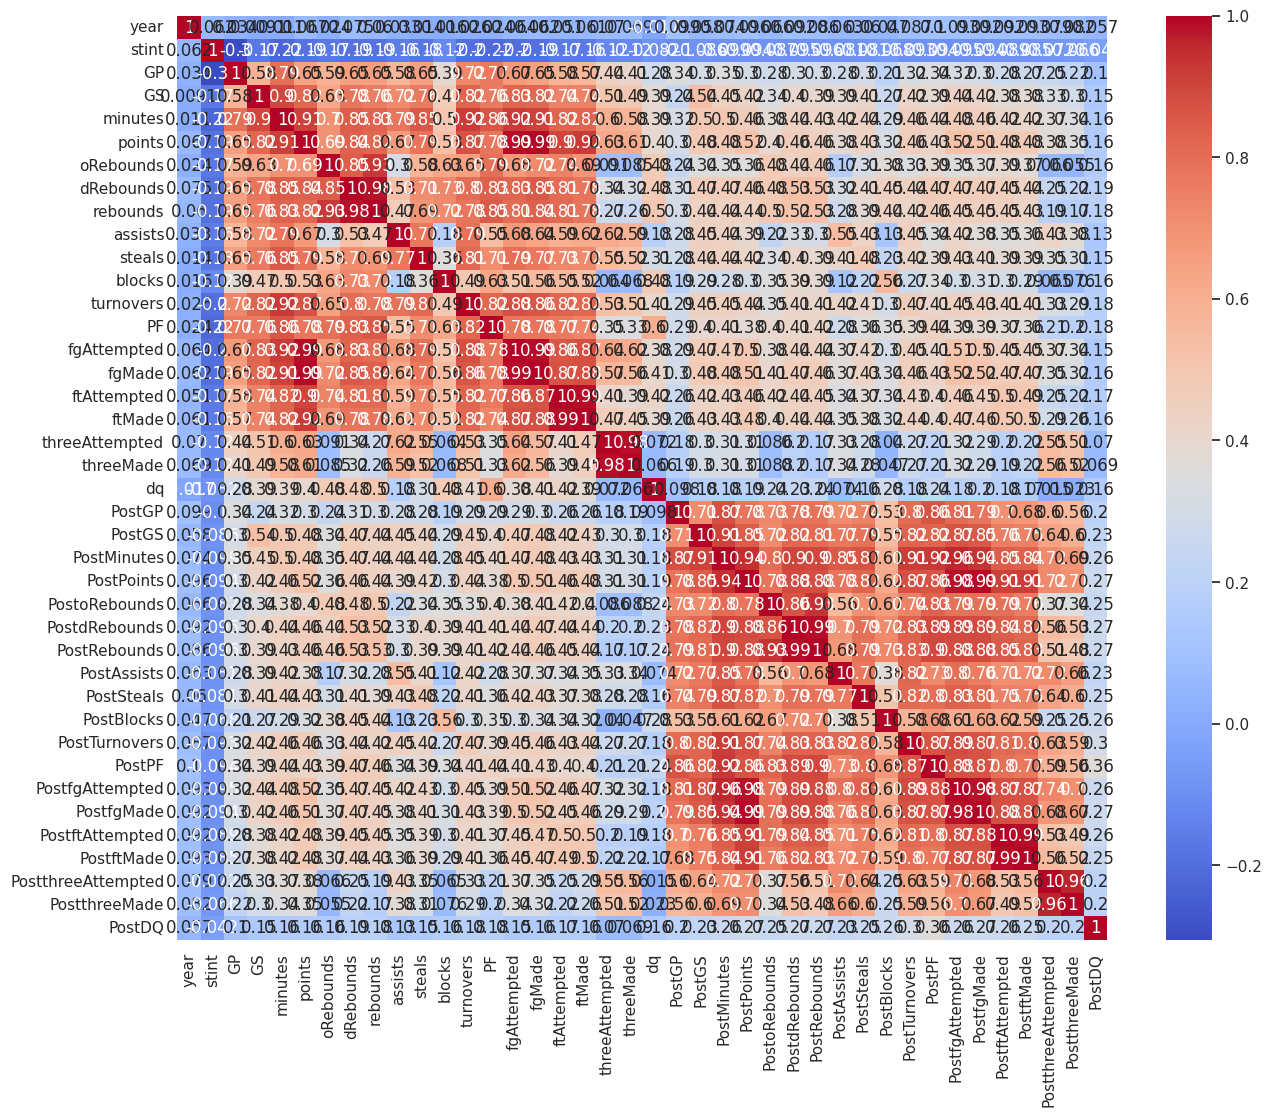

In [ ]:
# Calculate the correlation matrix
# remove non-number columns
pt_df = players_teams_df.drop(['playerID', 'tmID', 'lgID'], axis=1)
correlation_matrix = pt_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(15, 12))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Players_teams info

lgid is always 'WNBA'
No null values were detected


## Players

Basic Info

In [ ]:
# Display the first few rows of the dataset
#print(players_df.head())

# Get information about the columns and data types (missing values)
print(players_df.info())

# Get basic statistics of numerical columns
print(players_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bioID         893 non-null    object 
 1   pos           815 non-null    object 
 2   firstseason   893 non-null    int64  
 3   lastseason    893 non-null    int64  
 4   height        893 non-null    float64
 5   weight        893 non-null    int64  
 6   college       726 non-null    object 
 7   collegeOther  11 non-null     object 
 8   birthDate     893 non-null    object 
 9   deathDate     893 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 69.9+ KB
None
       firstseason  lastseason      height      weight
count        893.0       893.0  893.000000  893.000000
mean           0.0         0.0   65.500560  145.415454
std            0.0         0.0   20.940425   61.275703
min            0.0         0.0    0.000000    0.000000
25%            0.0         0.0   68.

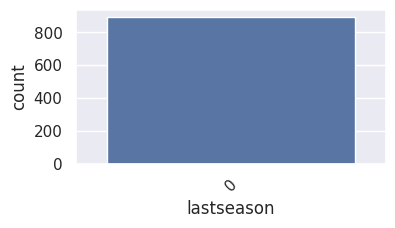

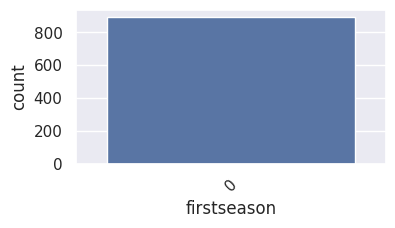

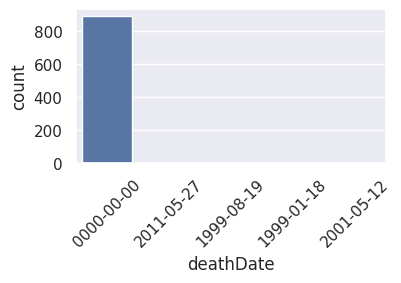

In [ ]:
# Plot count plots for players
plt.figure(figsize=(4, 2))
sb.countplot(x='lastseason', data=players_df)
plt.xticks(rotation=45)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(4, 2))
sb.countplot(x='firstseason', data=players_df)
plt.xticks(rotation=45)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(4, 2))
sb.countplot(x='deathDate', data=players_df)
plt.xticks(rotation=45)
plt.show()



In [ ]:
# # Calculate the correlation matrix
# correlation_matrix = players_df.corr()

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

### Player info

firstSeason and lastSeason are always 0 <br>
collegeOther only has 11 entries the rest is null (a lot of null vals)<br>
deathDate is almost always 0000-00-00 and seems irrelevant to the study<br>
pos and College have some missing values



# Teams Table

### Null or irrelevant columns

- franchID, lgID, divID, rank, seeded, name
- tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB
- GP, homeW, homeL, awayW, awayL, confW, confL
- min, attend, arena

### Transformations 
- make made/attempted ---> combined_stat = 0.5 * o_fgm/o_fga + 0.5 * o_fgm
    - o_fgm/o_fga, o_ftm/o_fta, o_3pm/o_3pa (teams stats)
    - d_fgm/d_fga, d_ftm/d_fta, d_3pm/d_3pa (opponent stats)
- del o_asts and d_asts?
- make a wlRatio (won/lost)

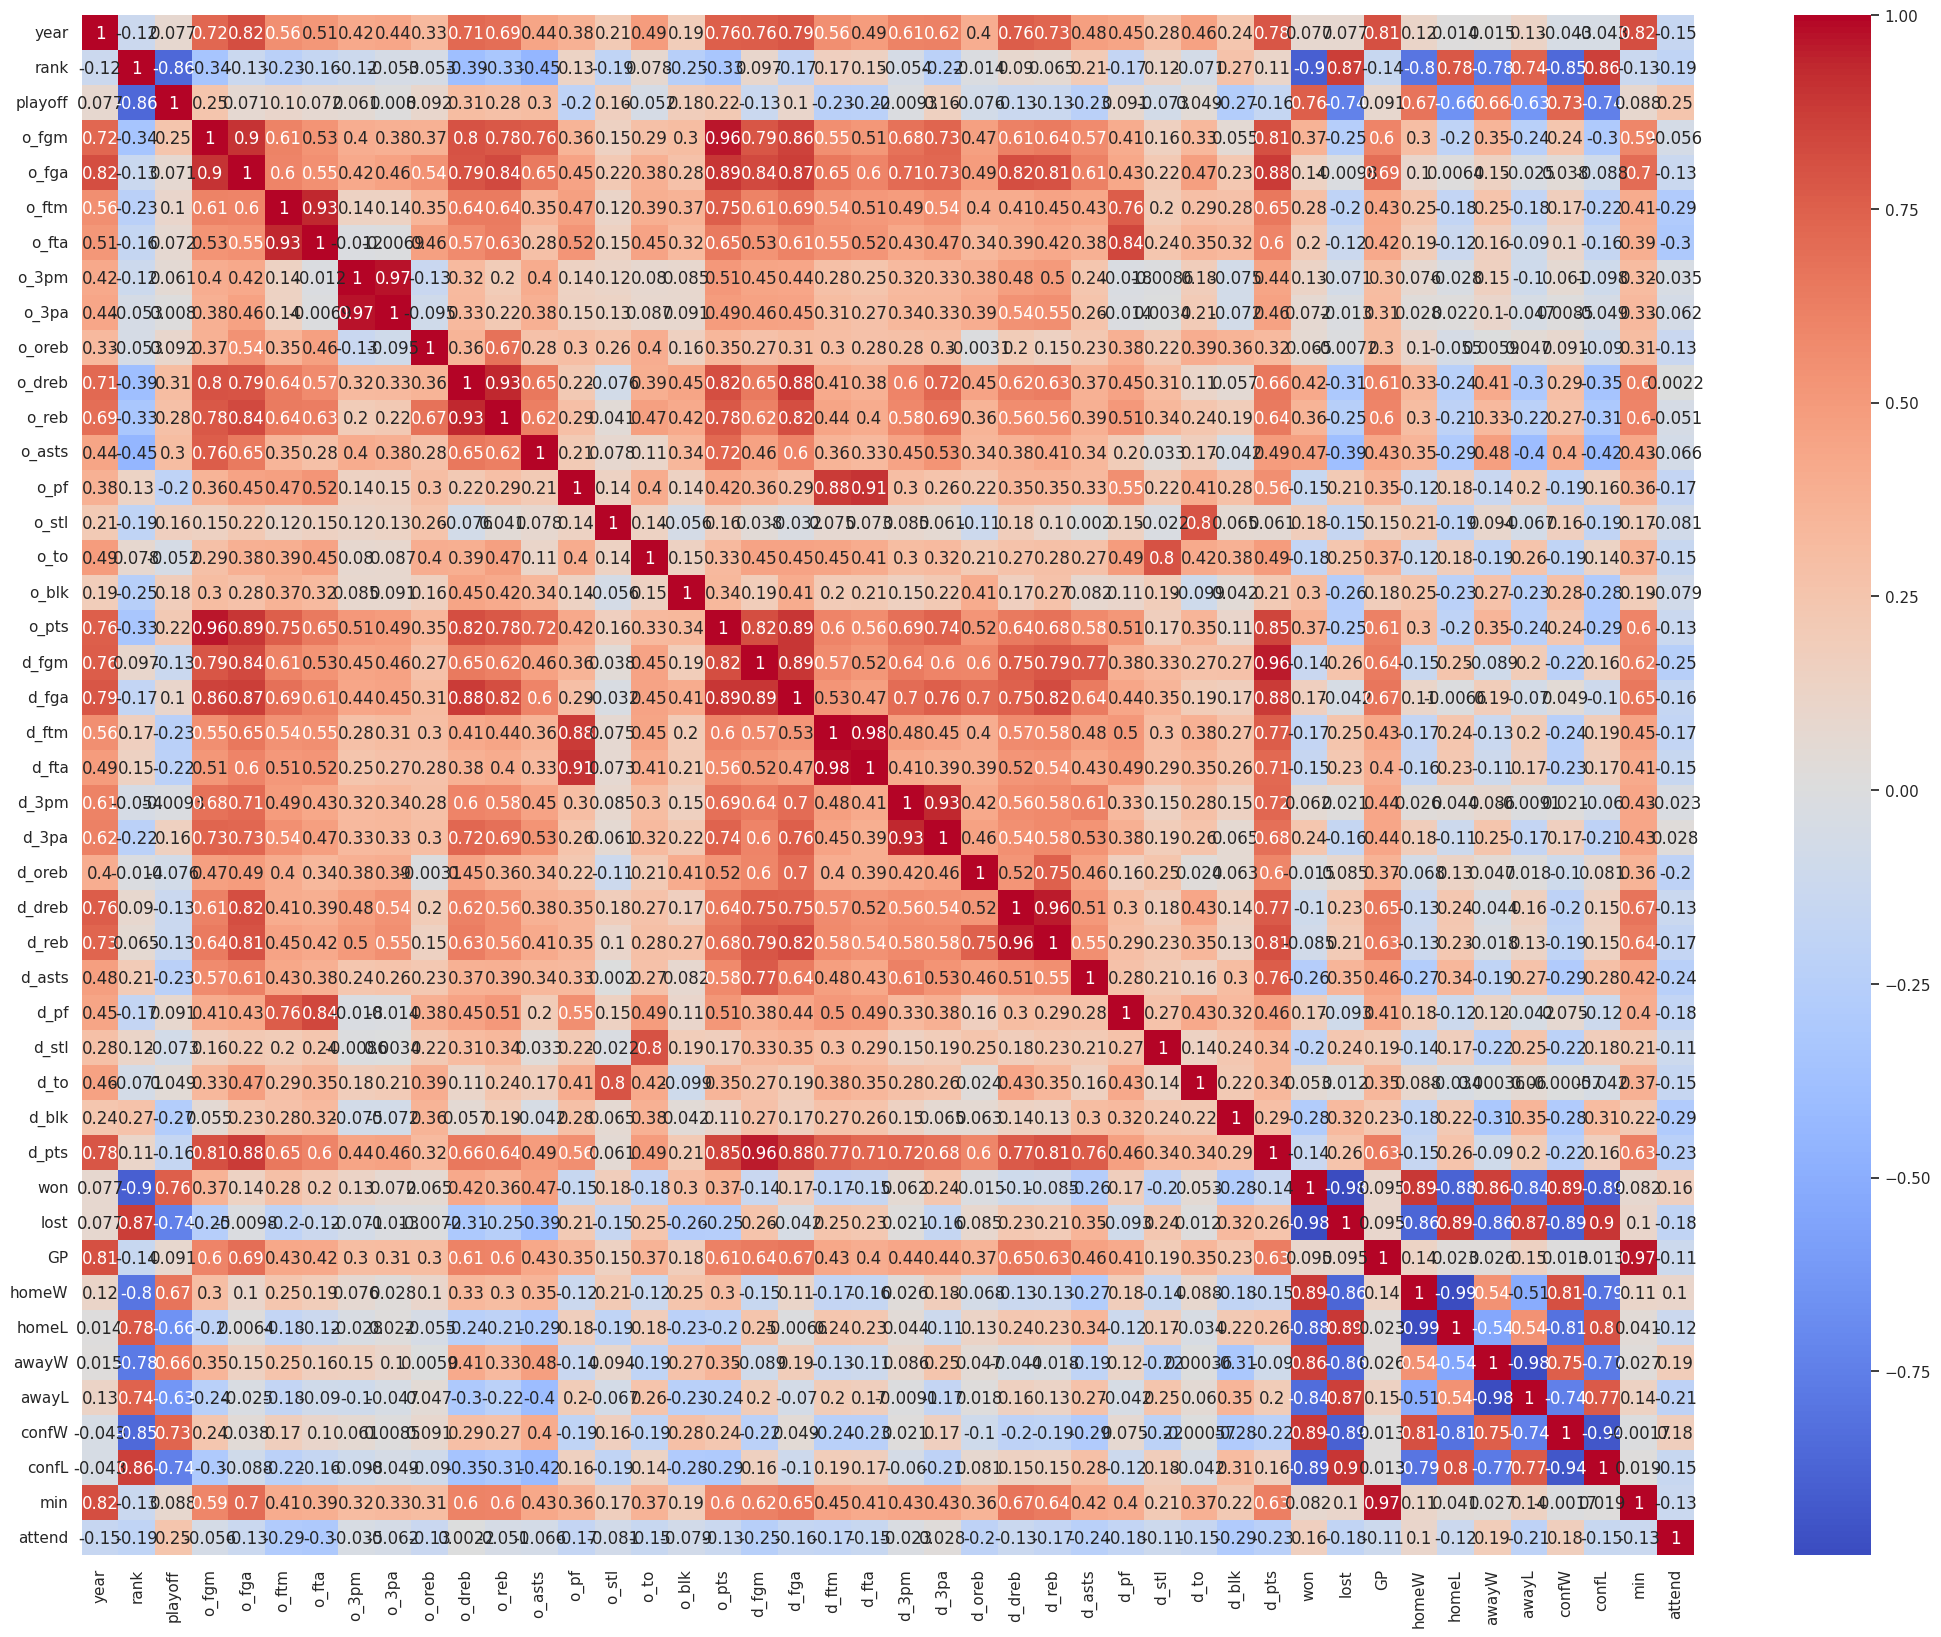

In [ ]:
# Correlation Matrix


teams_df['playoff'] = teams_df['playoff'].eq('Y').mul(1)

# only the numeric values
teams_df_numeric = teams_df.select_dtypes(include='number')

to_drop = []
for column in teams_df_numeric.columns:
    if (column == 'divID') or (teams_df_numeric[column] == 0).all():
        to_drop.append(column)

teams_df_numeric.drop(columns=to_drop, inplace=True)

plt.figure(figsize=(26, 20))
sb.heatmap(teams_df_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()


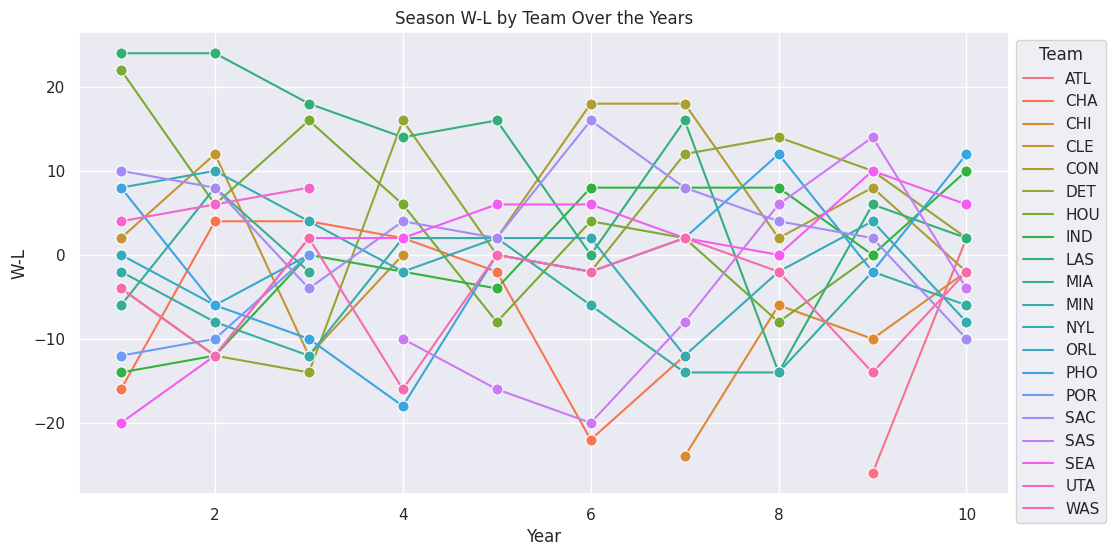

In [ ]:
teams_df['W-L'] = teams_df['won']-teams_df['lost']

sb.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sb.lineplot(data=teams_df, x='year', y='W-L', hue='tmID', marker="o", markersize=8, dashes=False)
plt.xlabel('Year')
plt.ylabel('W-L')
plt.title('Season W-L by Team Over the Years')
plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Teams Playoff Appearances
playoff_teams = teams_df[teams_df['playoff'] == 1]
playoff_counts = playoff_teams['tmID'].value_counts().reset_index()
playoff_counts.columns = ['Team', 'Playoff Appearances']
playoff_counts

Team  Playoff Appearances
0   LAS                    9
1   SAC                    8
2   DET                    7
3   NYL                    7
4   SEA                    7
5   CON                    6
6   HOU                    6
7   IND                    6
8   WAS                    5
9   SAS                    3
10  CLE                    3
11  CHA                    3
12  PHO                    3
13  UTA                    2
14  MIN                    2
15  ORL                    1
16  MIA                    1
17  ATL                    1

Because we are working with data that precedes 2015, 4 teams will be chosen from each conference, instead of choosing the best 8 from the league [<a href="ref1">1</a>].

In [ ]:
# playoff teams per conference per year
playoff_teams = teams_df[teams_df['playoff'] == 1]
playoff_teams = playoff_teams.groupby(['year', 'confID'])['tmID'].count().reset_index()
playoff_teams.columns = ['Year', 'Conference', 'Playoff Teams']
playoff_teams


Year Conference  Playoff Teams
0      1         EA              4
1      1         WE              4
2      2         EA              4
3      2         WE              4
4      3         EA              4
5      3         WE              4
6      4         EA              4
7      4         WE              4
8      5         EA              4
9      5         WE              4
10     6         EA              4
11     6         WE              4
12     7         EA              4
13     7         WE              4
14     8         EA              4
15     8         WE              4
16     9         EA              4
17     9         WE              4
18    10         EA              4
19    10         WE              4

# Teams Post Table

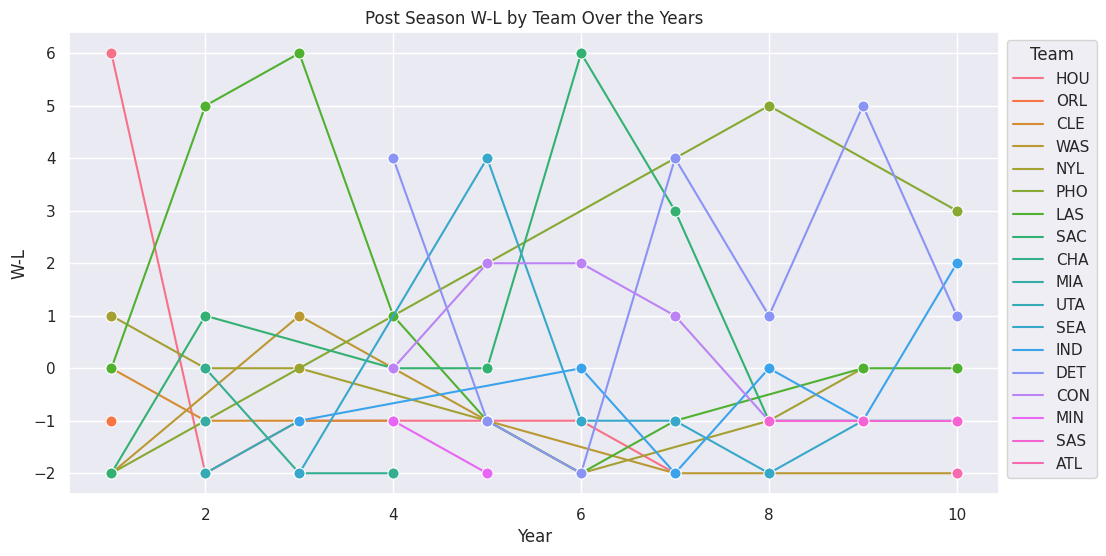

'Bar Graph'

In [ ]:
teams_post_df['W-L'] = teams_post_df['W'] - teams_post_df['L'] 

"""Point Graph"""
sb.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sb.lineplot(data=teams_post_df, x='year', y='W-L', hue='tmID', marker="o", markersize=8, dashes=False)
plt.xlabel('Year')
plt.ylabel('W-L')
plt.title('Post Season W-L by Team Over the Years')
plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

"""Bar Graph"""
# sb.set(style="darkgrid")
# plt.figure(figsize=(12, 6))
# sb.barplot(data=teams_post_df, x='year', y='W-L', hue='tmID', palette='Set1')
# plt.xlabel('Year')
# plt.ylabel('W-L')
# plt.title('Post Season W-L by Team Over the Years')
# plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

# Series Post Table

In [ ]:
# PlayOffs winning teams:
playoff_wins_df = series_post_df[series_post_df['round'] == 'F']
playoff_wins = playoff_wins_df.groupby('tmIDWinner').size().reset_index(name='PlayOffWins').sort_values(by='PlayOffWins',ascending=False)

playoff_wins

tmIDWinner  PlayOffWins
0        DET            3
2        LAS            2
3        PHO            2
1        HOU            1
4        SAC            1
5        SEA            1

### References

<a id="ref1"></a> [1] WNBA approves new playoff format - WNBA. (n.d.). https://www.wnba.com/news/wnba-approves-new-playoff-format